In [1]:
from kbmodpy import kbmod as kb
from trajectoryFiltering import *
import numpy as np
import random as rd
import math
import matplotlib.pyplot as plt
import os
%matplotlib inline

In [2]:
path = '../../HITS/test_35/4,6tempExp/new_header/'

In [3]:
files = os.listdir(path)

In [4]:
files.sort()
files = [path+f for f in files]
files = files[:4]
files

['../../HITS/test_35/4,6tempExp/new_header/v410913-fg.fits',
 '../../HITS/test_35/4,6tempExp/new_header/v410969-fg.fits',
 '../../HITS/test_35/4,6tempExp/new_header/v411019-fg.fits',
 '../../HITS/test_35/4,6tempExp/new_header/v411053-fg.fits']

In [5]:
images = [kb.layered_image(f) for f in files]

Object Generation Parameters

In [6]:
p = kb.psf(1.5)
object_count = 24
x_range = (5,3650)
y_range = (5, 3650)
angle_range = (0.1, 0.5)
velocity_range = (1900, 2900)
flux_range = (800, 4000)

Search Parameters

In [7]:
min_observations = 3
angle_steps = 200
velocity_steps = 180
search_margin = 1.2

In [8]:
print(angle_range[1]-angle_range[0])
print(velocity_range[1]-velocity_range[0])

0.4
1000


Generate Random trajectories within bounds

In [9]:
results_key = []
for _ in range(object_count):
    traj = kb.trajectory()
    traj.x = int(rd.uniform(*x_range))
    traj.y = int(rd.uniform(*y_range))
    ang = rd.uniform(*angle_range)
    vel = rd.uniform(*velocity_range)
    traj.x_v = vel*math.cos(ang)
    traj.y_v = vel*math.sin(ang)
    traj.flux = rd.uniform(*flux_range)
    results_key.append(traj)

Add a real object to the list of trajectories

In [10]:
if path == '../../HITS/test_35/4,6tempExp/new_header/':
    real_result = kb.trajectory()
    real_result.flux = 5300
    real_result.x = 3123
    real_result.y = 3043
    real_result.x_v = 2425
    real_result.y_v = 1050
    results_key.append(real_result)
results_key[0]

lh: 0.000000 flux: 3862.174561 x: 943 y: 240 x_v: 2338.804199 y_v: 1216.826660 obs_count: 0

Test that clustering is not able to collapse together too many unique trajectories

In [11]:
len(cluster_trajectories(results_key, dbscan_args=dict(eps=0.007, min_samples=1))[1])

25

Use the generated trajectories to add objects into the images

In [12]:
for t in results_key:
    add_trajectory(images, t, p)

Sanity check

In [13]:
len(match_trajectories(results_key, results_key, 0.01, 1)[0])

25

In [14]:
stack = kb.image_stack(images)

Mask out stars and bad pixels

In [15]:
flags = ~0 # mask pixels with any flags
flag_exceptions = [32,39] # unless it has one of these special combinations of flags
master_flags = int('100111', 2) # mask any pixels which have any of 
# these flags in more than two images

In [16]:
stack.apply_mask_flags(flags, flag_exceptions)

In [17]:
stack.apply_master_mask(master_flags, 2)

In [18]:
images = [i.science() for i in stack.get_images()]

Calculate masked percentage of an image to estimate probablilty of placing an object under a mask

In [25]:
img = images[1]
percent_masked = img[np.where(img==-9999.99)].size/img.size
percent_masked

0.15934744897959183

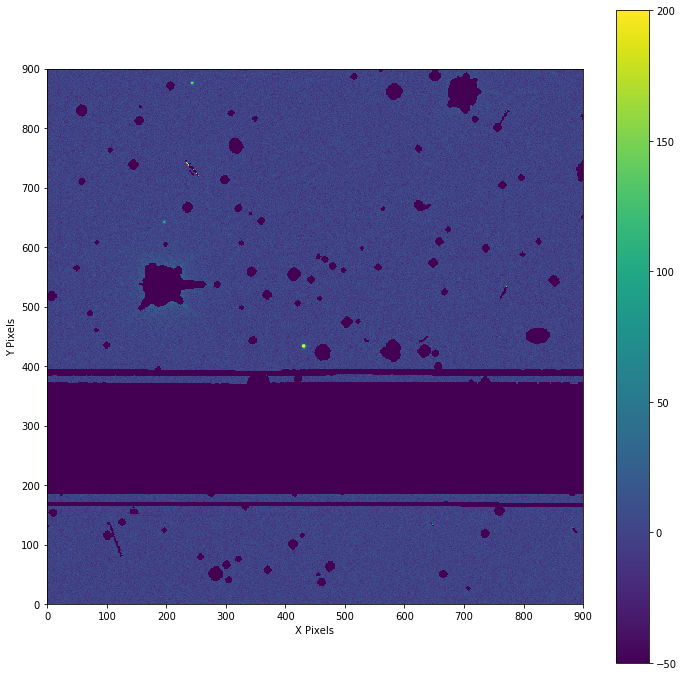

In [26]:
fig = plt.figure(figsize=(12,12))
plt.imshow(images[1] [2700:3600,2900:3800], origin='lower',  vmin=-50, vmax=200)#cmap=plt.cm.Greys_r,
plt.xlabel('X Pixels')
plt.ylabel('Y Pixels')
plt.colorbar()

In [27]:
search = kb.stack_search(stack, p)

In [28]:
search_ang_r = (angle_range[0]/search_margin,
                angle_range[1]*search_margin)
search_vel_r = (velocity_range[0]/search_margin,
                velocity_range[1]*search_margin)
search.gpu(angle_steps,velocity_steps, *angle_range, *velocity_range, min_observations)

In [29]:
psi_imgs = search.get_psi()

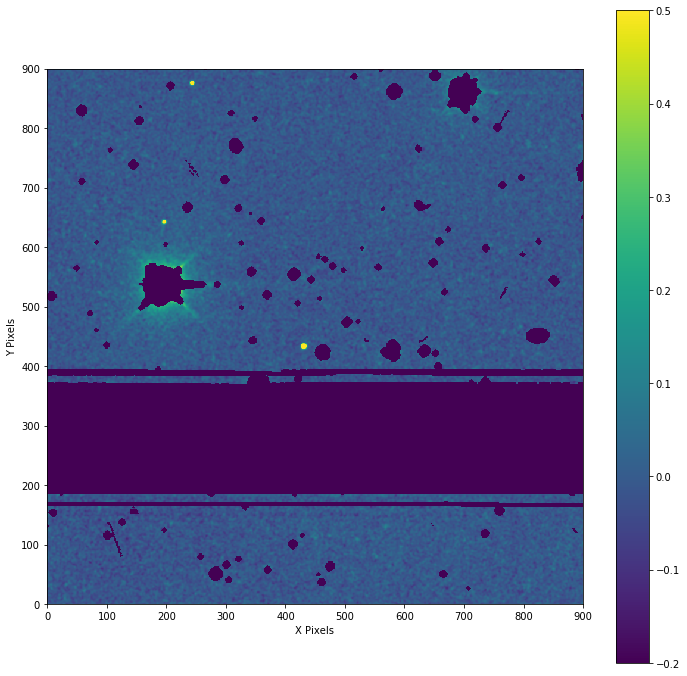

In [30]:
fig = plt.figure(figsize=(12,12))
plt.imshow(psi_imgs[1][2700:3600,2900:3800], origin='lower',  vmin=-0.2, vmax=0.5)#cmap=plt.cm.Greys_r,
plt.xlabel('X Pixels')
plt.ylabel('Y Pixels')
plt.colorbar()

In [31]:
#search.filter_min_obs(min_observations)

In [32]:
results = search.get_results(0, 150000)

In [33]:
#results = [t for t in results if t.obs_count>=min_observations]

In [34]:
len(results)

150000

Cluster results

In [35]:
results_clustered = [ results[i] 
    for i in cluster_trajectories(results, dbscan_args=dict(eps=0.004, min_samples=1))[1] ]

In [36]:
#search.save_results("filtered.txt", 0.03)

In [37]:
len(results_clustered)

39295

In [38]:
#results_clustered

In [39]:
#results_key

Calculate an upper bound for number of detections

In [40]:
maximum_expected_detections(stack.img_count(), min_observations, percent_masked, len(results_key))

21.95212117783789

In [41]:
results_matched, results_unmatched = match_trajectories(results_clustered, results_key, 0.02, 1)
print('matched: '+ str(len(results_matched)))
print('unmatched: ' + str(len(results_unmatched)))

matched: 18
unmatched: 7


In [42]:
results_matched

[lh: 270.433838 flux: 9907.183594 x: 3123 y: 3044 x_v: 2429.471924 y_v: 1044.390747 obs_count: 3,
 lh: 177.910095 flux: 3698.399170 x: 3543 y: 2171 x_v: 2091.817627 y_v: 472.165863 obs_count: 4,
 lh: 171.491806 flux: 3585.569824 x: 540 y: 2198 x_v: 2156.268799 y_v: 988.910156 obs_count: 4,
 lh: 154.917206 flux: 3239.388184 x: 204 y: 815 x_v: 1896.983032 y_v: 874.592529 obs_count: 4,
 lh: 151.953598 flux: 3652.949707 x: 943 y: 239 x_v: 2338.239258 y_v: 1223.262939 obs_count: 3,
 lh: 148.850555 flux: 3141.376953 x: 824 y: 1687 x_v: 1899.974243 y_v: 659.291748 obs_count: 4,
 lh: 144.326935 flux: 3234.585693 x: 56 y: 3485 x_v: 1930.577759 y_v: 311.555603 obs_count: 4,
 lh: 143.051086 flux: 3447.743164 x: 129 y: 618 x_v: 2080.073486 y_v: 749.870911 obs_count: 3,
 lh: 142.775436 flux: 3512.204102 x: 2392 y: 1454 x_v: 2418.341553 y_v: 716.399841 obs_count: 3,
 lh: 141.652176 flux: 3197.587891 x: 2968 y: 3517 x_v: 2048.825684 y_v: 669.875854 obs_count: 4,
 lh: 120.995346 flux: 2513.580322 x: 3

In [43]:
results_unmatched

[lh: 0.000000 flux: 837.320740 x: 1345 y: 269 x_v: 2830.928467 y_v: 341.890747 obs_count: 0,
 lh: 0.000000 flux: 1161.111084 x: 1831 y: 3631 x_v: 2537.676270 y_v: 1025.329956 obs_count: 0,
 lh: 0.000000 flux: 1241.025024 x: 3218 y: 2505 x_v: 2661.906738 y_v: 616.949341 obs_count: 0,
 lh: 0.000000 flux: 855.394775 x: 1887 y: 2698 x_v: 1965.241211 y_v: 257.468994 obs_count: 0,
 lh: 0.000000 flux: 895.441162 x: 69 y: 1773 x_v: 1948.393677 y_v: 671.977051 obs_count: 0,
 lh: 0.000000 flux: 1310.350830 x: 463 y: 1204 x_v: 2418.953369 y_v: 979.408081 obs_count: 0,
 lh: 0.000000 flux: 3465.107178 x: 1914 y: 3035 x_v: 2449.363525 y_v: 382.229919 obs_count: 0]

Choose the set of results to analyze

In [44]:
results_to_plot = results_unmatched
#                 results - raw results from the search
#                 results_clustered - raw results clustered
#                 results_matched - results that matched with the key
#                 reults_unmatched - results from the key that were not found
#                 results_key - the list of known artificial objects

In [45]:
stamps = [create_postage_stamp(images, t, stack.get_times(), [21,21])[0] for t in results_to_plot]

Starting at 0


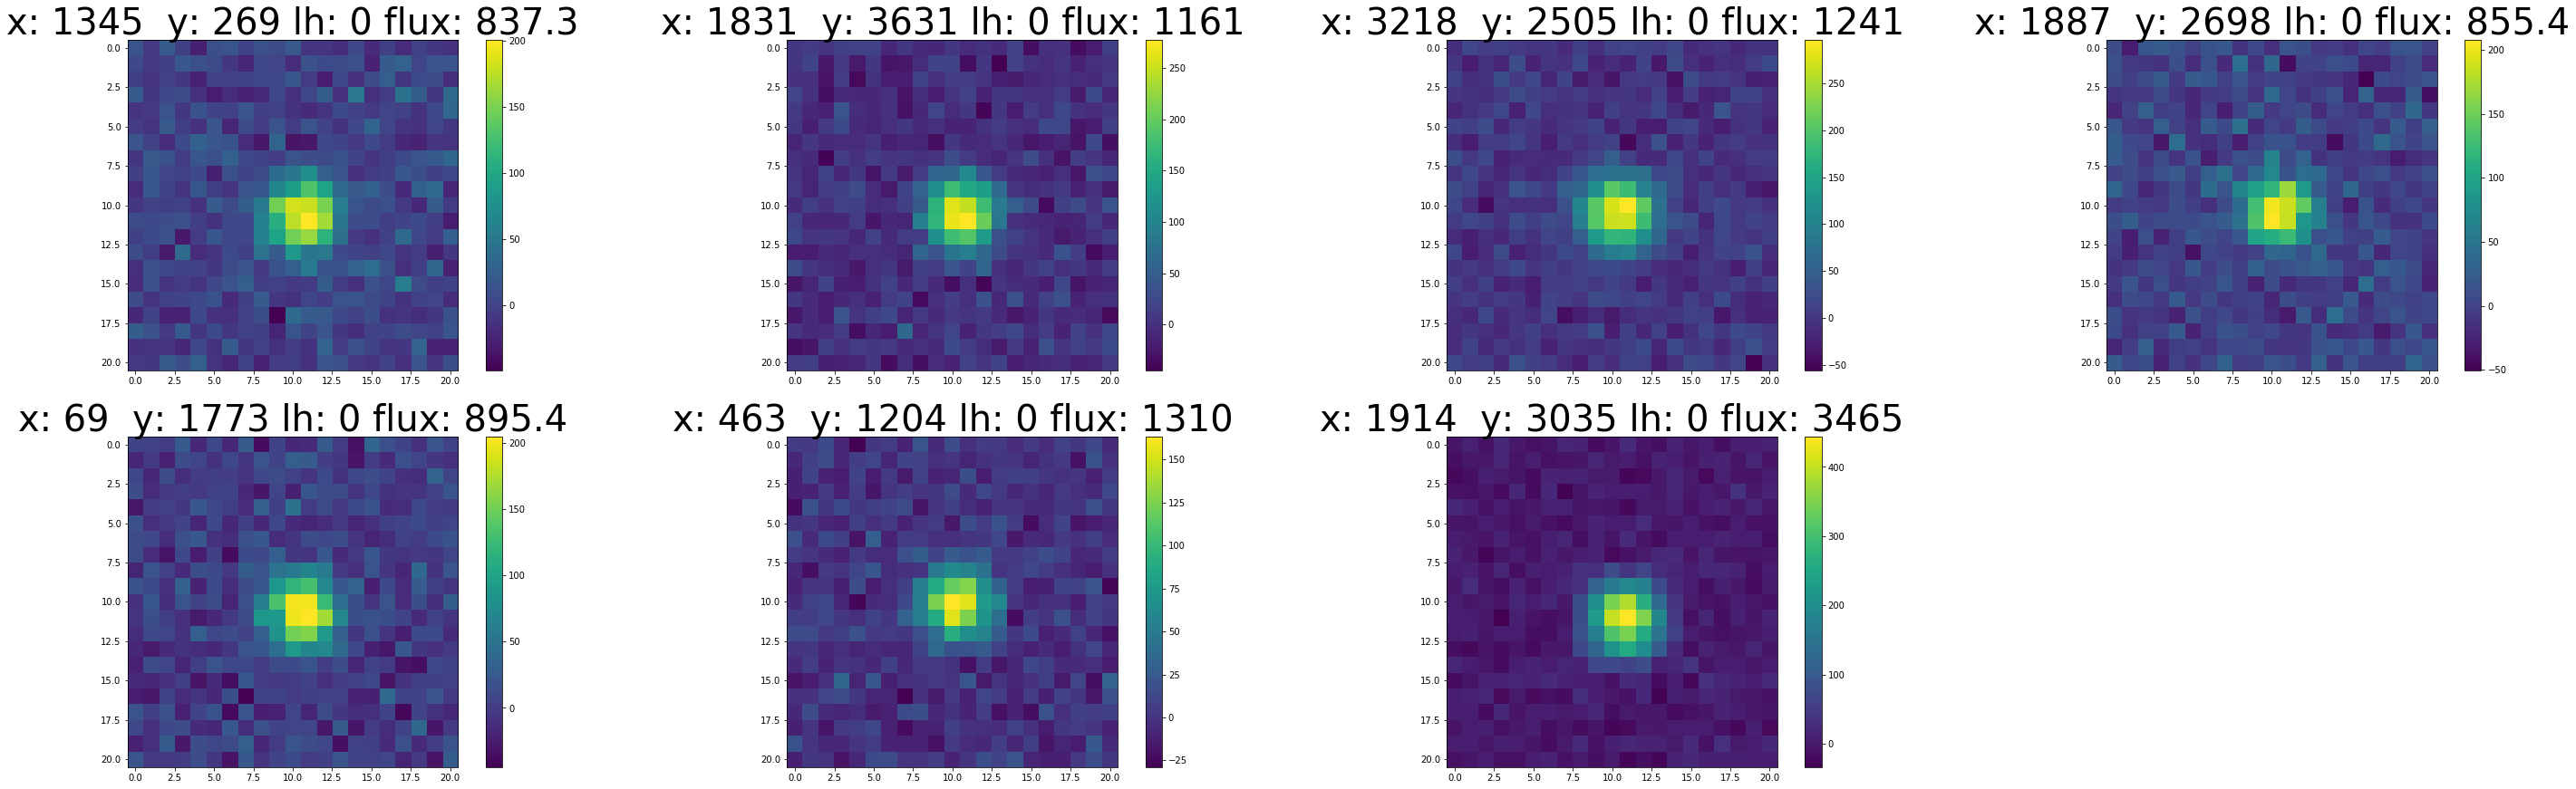

In [46]:
fig = plt.figure(figsize=(50, 200))
set_on = 1
plot_count = min(100,len(stamps))
print ('Starting at %i' % int((set_on - 1)*plot_count))
for i in range((set_on-1)*plot_count,set_on*plot_count):
    fig.add_subplot(25,4,i-(set_on-1)*plot_count+1)
    plt.imshow(stamps[i], #cmap=plt.cm.Greys_r,
               interpolation=None)
    rplt=results_to_plot[i]
    plt.title('x: {0}  y: {1} lh: {2:.3g} flux: {3:.4g}'.format(rplt.x, rplt.y,rplt.lh, rplt.flux) , fontsize=40)
    plt.colorbar()

In [413]:
def plot_histogram(results_to_plt, bins, x_rng, y_rng, name, title, color):
# the histogram of the data
    n, bins, patches = plt.hist(np.array(results_to_plt), bins, normed=0, facecolor=color, alpha=0.75)

    # add a 'best fit' line
    #y = mlab.normpdf( bins, mu, sigma)
    #l = plt.plot(bins, y, 'r--', linewidth=1)

    plt.xlabel(name)
    plt.ylabel('Detections')
    plt.title(title)
    #plt.axis([*x_rng, *y_rng])
    plt.grid(True)

    plt.show()

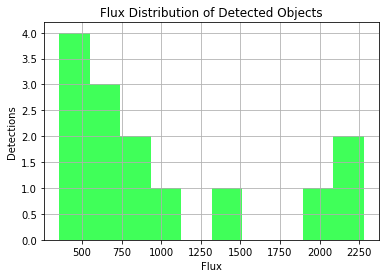

In [425]:
plot_histogram([t.flux for t in results_to_plot], 10, 
flux_range, (0,40), 'Flux', 'Flux Distribution of Detected Objects', '#00ff22')

In [415]:
#plot detection ratio for flux, lh, velocities, angle

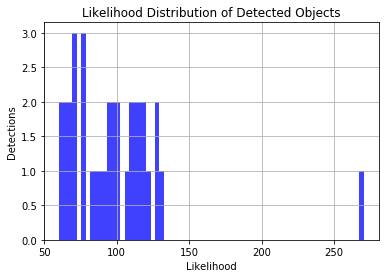

In [416]:
plot_histogram([t.lh for t in results_to_plot], 70,
(0, 350), (0,50), 'Likelihood', 'Likelihood Distribution of Detected Objects', 'blue')

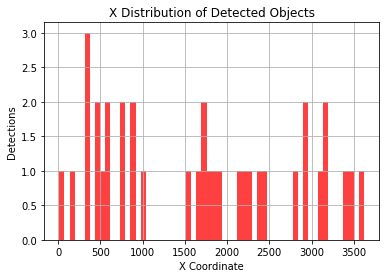

In [417]:
plot_histogram([t.x for t in results_to_plot], 60,
(0, 4096), (0,20), 'X Coordinate', 'X Distribution of Detected Objects', 'red')

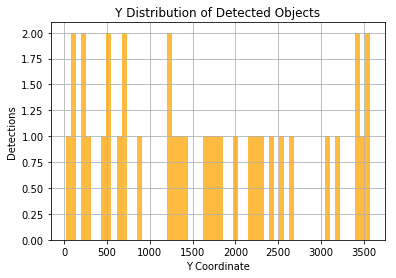

In [418]:
plot_histogram([t.y for t in results_to_plot], 60, 
(0, 4096), (0,20), 'Y Coordinate', 'Y Distribution of Detected Objects', 'orange')

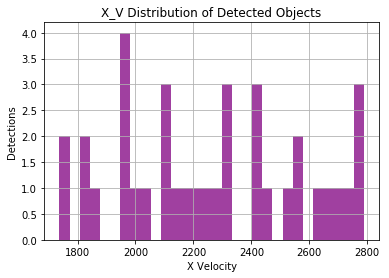

In [419]:
plot_histogram([t.x_v for t in results_to_plot], 30, 
(0, 4096), (0,20), 'X Velocity', 'X_V Distribution of Detected Objects', 'purple')

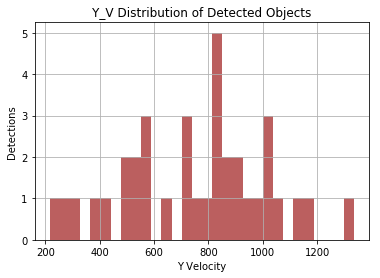

In [420]:
plot_histogram([t.y_v for t in results_to_plot], 30, 
(0, 4096), (0,20), 'Y Velocity', 'Y_V Distribution of Detected Objects', 'brown')